total load 4 images, size of images: (1216, 1936)


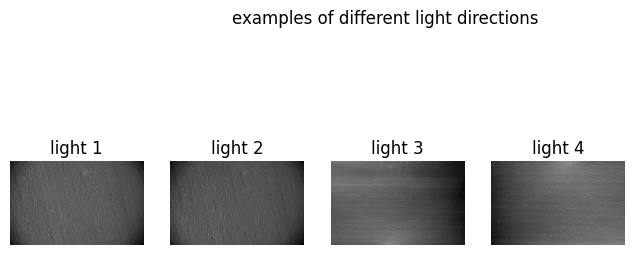

Matrix of light directions L:
[[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0. -1.  0.]
 [ 0.  1.  0.]]


In [24]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

image_dir = '/content/'
light_file = '/content/light_directions.txt'

#read images
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
images = []

#record size of the 1st image
first_shape = None

for f in image_files:
    img = cv2.imread(os.path.join(image_dir, f), cv2.IMREAD_GRAYSCALE).astype(np.float32)
    if first_shape is None:
        first_shape = img.shape
    if img.shape != first_shape:
        print(f"warning:size of {f}image {img.shape}，auto resize to {first_shape}！")
        img = cv2.resize(img, (first_shape[1], first_shape[0]))
    images.append(img)

I_stack = np.stack(images, axis=-1)  # H x W x N

print(f"total load {len(images)} images, size of images: {images[0].shape}")

#display the example
plt.figure(figsize=(10,4))
for i, img in enumerate(images[:5]):
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'light {i+1}')
    plt.axis('off')
plt.suptitle('examples of different light directions')
plt.show()

# load matrix of light directions L (N x 3)
L = np.loadtxt(light_file)
print("Matrix of light directions L:")
print(L)

Normal vector and reflectance estimation complete.


(np.float64(-0.5), np.float64(1935.5), np.float64(1215.5), np.float64(-0.5))

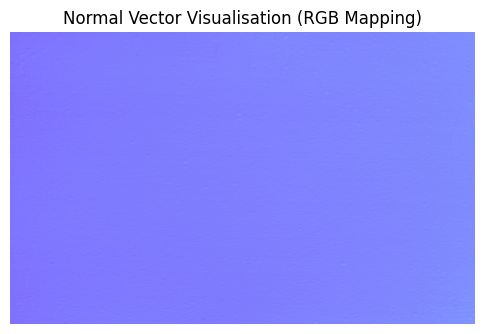

In [25]:
# reshape I_stack to (N) x (H*W)
H, W, N = I_stack.shape
I_flat = I_stack.reshape(-1, N).T  # transfer N x (H*W)

# Solve using least squares g_flat = rho*n_flat
# Solve: g_flat (3 x (H*W)) = (L^+ @ I_flat), where L^+ is the pseudo-inverse of L
L_pinv = np.linalg.pinv(L)  # 3 x N
g_flat = L_pinv.dot(I_flat)  # 3 x (H*W)

# Reshape the g_flat back into a spatial location
g = g_flat.T.reshape(H, W, 3)  # H x W x 3

# Calculate the normal vector. N_norm = g / ||g||
norm = np.linalg.norm(g, axis=2, keepdims=True) + 1e-8  # avoid 0
N_norm = g / norm  # H x W x 3
# Reflectance map rho
rho = norm[..., 0]  # The actual values are the same for all three channels

print("Normal vector and reflectance estimation complete.")

# Visualising the normal vector field (using RGB mapping)
normal_vis = (N_norm + 1) / 2  # Mapping to [0, 1] for easy visualisation.
plt.figure(figsize=(6,6))
plt.imshow(normal_vis)
plt.title('Normal Vector Visualisation (RGB Mapping)')
plt.axis('off')


<ipython-input-26-eb6712bbbb39>:18: RuntimeWarning: invalid value encountered in divide
  height_vis = (height - h_min) / (h_max - h_min)


(np.float64(-0.5), np.float64(1935.5), np.float64(1215.5), np.float64(-0.5))

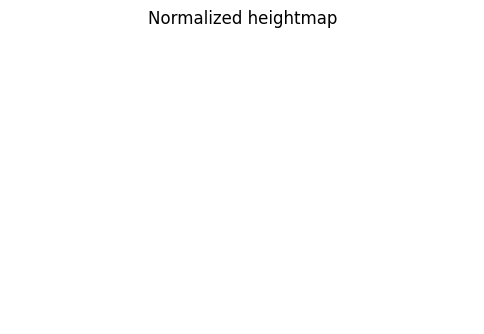

In [26]:
from scipy import integrate

# compute p, q
nx = N_norm[:, :, 0]
ny = N_norm[:, :, 1]
nz = N_norm[:, :, 2] + 1e-8  # avoid 0
p = -nx / nz
q = -ny / nz

# Recover the heightmap by accumulating gradient integration.
# Integrate in the x direction first, then in the y direction (or vice versa)
# integrate.cumtrapz returns a length 1 less than the original, using the initial parameter to keep the dimensions consistent.
height_x = integrate.cumulative_trapezoid(p, axis=1, initial=0)
height   = integrate.cumulative_trapezoid(height_x, axis=0, initial=0)

# Normalised height maps are used for visualisation.
h_min, h_max = height.min(), height.max()
height_vis = (height - h_min) / (h_max - h_min)

plt.figure(figsize=(6,6))
plt.imshow(height_vis, cmap='jet')
plt.title('Normalized heightmap')
plt.axis('off')


(np.float64(-0.5), np.float64(1935.5), np.float64(1215.5), np.float64(-0.5))

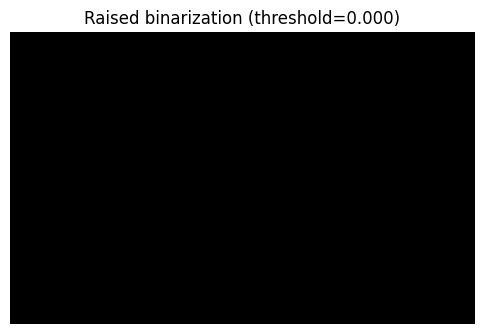

In [27]:
# Set thresholds based on height distribution (e.g. above mean + k*standard deviation)
h_mean = np.mean(height)
h_std = np.std(height)
threshold = h_mean + 1.5 * h_std  # k=1.5，adjustable

binary_height = (height > threshold).astype(np.uint8) * 255

plt.figure(figsize=(6,6))
plt.imshow(binary_height, cmap='gray')
plt.title(f'Raised binarization (threshold={threshold:.3f})')
plt.axis('off')


(np.float64(-0.5), np.float64(1935.5), np.float64(1215.5), np.float64(-0.5))

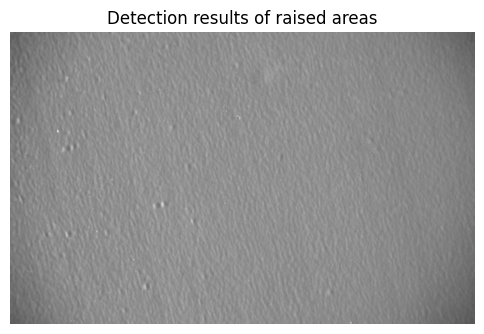

In [28]:
# Draws an outline of the raised area on the original image
img_vis = cv2.cvtColor(images[0].astype(np.uint8), cv2.COLOR_GRAY2BGR)
contours, _ = cv2.findContours(binary_height, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 50:  # Filters out small noises
        cv2.drawContours(img_vis, [cnt], -1, (0,0,255), 2)

plt.figure(figsize=(6,6))
plt.imshow(img_vis[..., ::-1])
plt.title('Detection results of raised areas')
plt.axis('off')


In [29]:
output_prefix = '/content/'

# Save the visualisation of the normals.
normal_vis_img = (normal_vis * 255).astype(np.uint8)
cv2.imwrite(output_prefix + '_normals.png', cv2.cvtColor(normal_vis_img, cv2.COLOR_RGB2BGR))

# Save Heightmap (Normalise)
height_uint8 = (height_vis * 255).astype(np.uint8)
cv2.imwrite(output_prefix + '_height.png', height_uint8)

# Save the binary bulge map
cv2.imwrite(output_prefix + '_bump_mask.png', binary_height)

# Save the image with the outline callout.
cv2.imwrite(output_prefix + '_bump_detected.png', img_vis)

print("saved:")
print(output_prefix + "_normals.png")
print(output_prefix + "_height.png")
print(output_prefix + "_bump_mask.png")
print(output_prefix + "_bump_detected.png")


saved:
/content/_normals.png
/content/_height.png
/content/_bump_mask.png
/content/_bump_detected.png


<ipython-input-29-0ab650d18c65>:8: RuntimeWarning: invalid value encountered in cast
  height_uint8 = (height_vis * 255).astype(np.uint8)
